In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
try:
    reload(galpy.df_src.streampepperdf)
    reload(galpy.df_src.streampepperdf.galpy.df_src.streamgapdf)
except NameError:
    import galpy.df_src.streampepperdf
import numpy
from galpy.potential import LogarithmicHaloPotential
from galpy.orbit import Orbit
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.util import bovy_conversion, bovy_coords
from galpy.util import bovy_plot
%pylab inline
R0, V0= 8., 220.

Populating the interactive namespace from numpy and matplotlib


# Computing stream peppering with *galpy*

We again work with the stream model from Sanders, Bovy, & Erkal (2015) as a baseline. We compute the combined effect of two impacts at the same time, but 1 radian in parallel angle apart (both are $10^8\,M_\odot$). The probability $p(\Omega_\parallel,\theta_\parallel)$ and the mean are given by:

In [3]:
lp= LogarithmicHaloPotential(normalize=1.,q=0.9)
xv_prog_init= numpy.array([30.,0.,0.,0., 105.74895, 105.74895])
def convert_to_cylindrical(xv):
    R,phi,Z= bovy_coords.rect_to_cyl(xv[:,0],xv[:,1],xv[:,2])
    vR,vT,vZ= bovy_coords.rect_to_cyl_vec(xv[:,3],xv[:,4],xv[:,5],R,phi,Z,cyl=True)
    out= numpy.empty_like(xv)
    # Preferred galpy arrangement of cylindrical coordinates
    out[:,0]= R
    out[:,1]= vR
    out[:,2]= vT
    out[:,3]= Z
    out[:,4]= vZ
    out[:,5]= phi
    return out
sigv= 0.365*(10./2.)**(1./3.)
RvR_prog_init= convert_to_cylindrical(xv_prog_init[:,numpy.newaxis].T)[0,:]
prog_init= Orbit([RvR_prog_init[0]/R0,RvR_prog_init[1]/V0,RvR_prog_init[2]/V0,
                  RvR_prog_init[3]/R0,RvR_prog_init[4]/V0,RvR_prog_init[5]])
times= numpy.linspace(0.,10.88/bovy_conversion.time_in_Gyr(V0,R0),10001)
prog_init.integrate(times,lp)
xv_unp_peri_prog= [prog_init.x(times[-1])[0],prog_init.y(times[-1])[0],prog_init.z(times[-1]),
              prog_init.vx(times[-1])[0],prog_init.vy(times[-1])[0],prog_init.vz(times[-1])]
RvR_unp_peri_prog= convert_to_cylindrical(numpy.array(xv_unp_peri_prog)[:,numpy.newaxis].T)[0,:]
prog_unp_peri= Orbit([RvR_unp_peri_prog[0],RvR_unp_peri_prog[1],RvR_unp_peri_prog[2],
                      RvR_unp_peri_prog[3]+0.0,RvR_unp_peri_prog[4],RvR_unp_peri_prog[5]])
aAI= actionAngleIsochroneApprox(pot=lp,b=0.8)

In [4]:
sdf_pepper= galpy.df_src.streampepperdf.streampepperdf(\
    sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
    leading=False,nTrackChunks=26,nTrackIterations=1,
    sigMeanOffset=4.5,
    tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
    Vnorm=V0,Rnorm=R0,
    impactb=[0.,0.],
    subhalovel=numpy.array([[6.82200571,132.7700529,149.4174464],
                            [6.82200571,132.7700529,149.4174464]])/V0, # from Denis' email
    timpact=[0.88/bovy_conversion.time_in_Gyr(V0,R0),0.88/bovy_conversion.time_in_Gyr(V0,R0)],
    impact_angle=[-2.34,-1.34],
    GM=[10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),10.**-2./bovy_conversion.mass_in_1010msol(V0,R0)],
    rs=[0.625/R0,0.625/R0]) 

In [5]:
xs= numpy.linspace(0.,4.5,101)
mO= numpy.array([sdf_pepper.meanOmega(x,oned=True) for x in xs])
mO_unp= numpy.array([super(galpy.df_src.streampepperdf.streampepperdf,sdf_pepper).meanOmega(x,oned=True) for x in xs])

/Users/bovy/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):



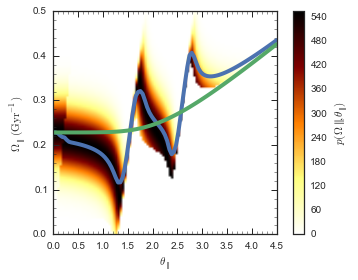

In [6]:
Opars= numpy.linspace(0.,0.5,101)/bovy_conversion.freq_in_Gyr(V0,R0)
apars= numpy.linspace(0.,4.5,101)
y= numpy.array([sdf_pepper.pOparapar(Opars,a) for a in apars])
bovy_plot.bovy_dens2d(y.T,
                      origin='lower',
                      cmap='afmhot_r',colorbar=True,
                      vmin=0.,
                      xrange=[apars[0],apars[-1]],
                      yrange=[Opars[0]*bovy_conversion.freq_in_Gyr(V0,R0),
                              Opars[-1]*bovy_conversion.freq_in_Gyr(V0,R0)],
                     zlabel=r'$p(\Omega\parallel,\theta_\parallel)$')
plot(xs,mO*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
plot(xs,mO_unp*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
xlabel(r'$\theta_\parallel$')
ylabel(r'$\Omega_\parallel\,(\mathrm{Gyr}^{-1})$')

The density along the stream is

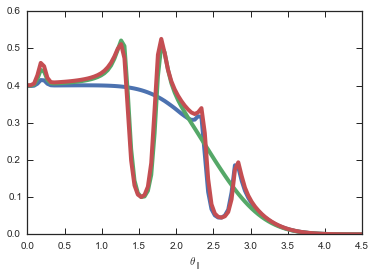

In [7]:
xs= numpy.linspace(0.,4.5,101)
dens= numpy.array([sdf_pepper._sgapdfs[0].density_par(x) for x in xs])
plot(xs,dens/numpy.sum(dens)/(xs[1]-xs[0]),lw=4.)
dens= numpy.array([sdf_pepper._sgapdfs[1].density_par(x) for x in xs])
plot(xs,dens/numpy.sum(dens)/(xs[1]-xs[0]),lw=4.)
dens= numpy.array([sdf_pepper.density_par(x) for x in xs])
plot(xs,dens/numpy.sum(dens)/(xs[1]-xs[0]),lw=4.)
xlabel(r'$\theta_\parallel$')

Let's try the same for two $10^5\,M_\odot$ impacts. Can we get the frequency deviation accurately with this code? The frequency deviation is

In [8]:
sdf_pepper._determine_deltaOmegaTheta_kicks([-2.34,-1.34],[0.,0.],
                                            numpy.array([[6.82200571,132.7700529,149.4174464],
                                                         [6.82200571,132.7700529,149.4174464]])/V0,
                                           [0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                            0.88/bovy_conversion.time_in_Gyr(V0,R0)],
                                            [10.**-5./bovy_conversion.mass_in_1010msol(V0,R0),
                                             10.**-5./bovy_conversion.mass_in_1010msol(V0,R0)],
                                           [0.625/R0,0.625/R0],[None,None])

In [9]:
xs= numpy.linspace(0.,4.5,101)
mO= numpy.array([sdf_pepper.meanOmega(x,oned=True) for x in xs])
mO_unp= numpy.array([super(galpy.df_src.streampepperdf.streampepperdf,sdf_pepper).meanOmega(x,oned=True) for x in xs])

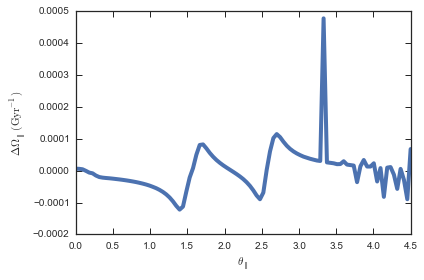

In [10]:
plot(xs,(mO-mO_unp)*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
#plot(xs,mO_unp*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
xlabel(r'$\theta_\parallel$')
ylabel(r'$\Delta\Omega_\parallel\,(\mathrm{Gyr}^{-1})$')

and the density

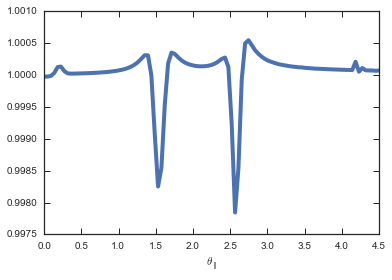

In [11]:
dens= numpy.array([sdf_pepper.density_par(x) for x in xs])
dens_unp= numpy.array([super(galpy.df_src.streampepperdf.streampepperdf,sdf_pepper).density_par(x) for x in xs])
plot(xs,(dens/numpy.sum(dens))/(dens_unp/numpy.sum(dens_unp)),lw=4.)
xlabel(r'$\theta_\parallel$')

There's some issues where the stream starts to run out of stars, but overall this works quite well already ...